# Anomaly Detection: make_blobs data

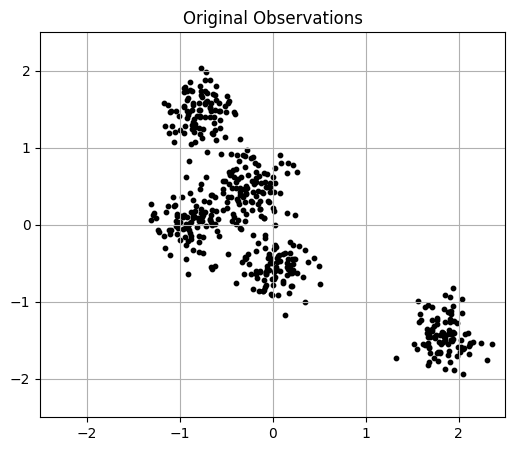

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
from sklearn.svm import OneClassSVM

X, y_true = make_blobs(n_samples=500, 
                       centers=5,
                       cluster_std=0.80, 
                       random_state=0)

X = StandardScaler().fit_transform(X)

fig = plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=10, color='k')
plt.axis([-2.5, 2.5, -2.5, 2.5])
plt.title('Original Observations')
plt.grid()
plt.show()

## Perform Elliptic Envelope

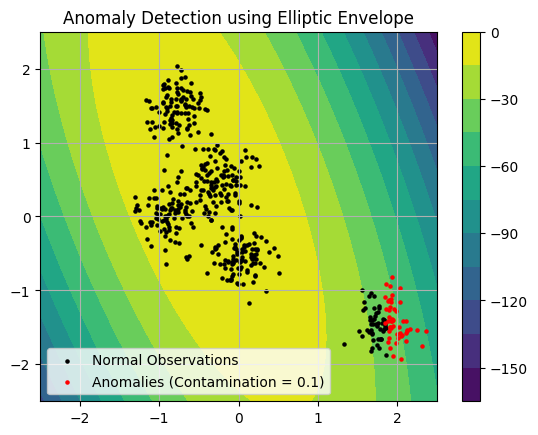

In [2]:
# Make a meshgrid for plotting surfaces
Xp, Yp = np.meshgrid(np.linspace(-2.5,2.5),np.linspace(-2.5,2.5))
XY = np.vstack([Xp.ravel(), Yp.ravel()]).T

envelope = EllipticEnvelope(random_state=0, contamination=0.1).fit(X)
Zp = envelope.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = envelope.predict(X)
normals = X[y_pred == 1,:]
anomals = X[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=10, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (Contamination = 0.1)')
plt.title('Anomaly Detection using Elliptic Envelope')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

The Elliptic Envelope assumes that the data has a multivariate Gaussian distribution. Hence, for non-Gaussian and/or multi-modal distributed data, this method fails to find anomalies well. Also, instead of a confidence level, the number of outliers to be detected by this method can be controlled by setting a contamination parameter. Be default, this contamination parameter is set to 0.1. 

## Perform 2D Kernel Density Estimation

Threshold (KDE) = 0.1019869147985261


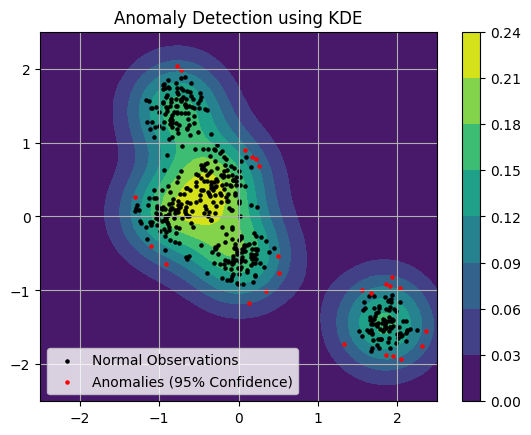

In [3]:
# Generate the KDE surface as Z
kde = KernelDensity(kernel='gaussian',bandwidth=0.4).fit(X)
Zp = np.exp(kde.score_samples(XY))
Zp = Zp.reshape(Xp.shape)

# Establish a confidence level of 95% (or 5% cutoff) 
# for the UCL using the quantile of kde_scores.
scores = kde.score_samples(X)
threshold = np.quantile(scores,0.05)
print(f"Threshold (KDE) = {np.exp(threshold)}")

# Get the anomalous data points
normals = X[scores > threshold,:]
anomals = X[scores <= threshold,:]

cntr = plt.contourf(Xp, Yp, Zp, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (95% Confidence)')
plt.title('Anomaly Detection using KDE')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

In this implementation of KDE for anomaly detection, only the quantile statistic of the KDE scores was used to find anomalies. This approach only gives us an empirical threshold. The actual threshold should be computed by integrating the KDE score surface and finding the threshold $T$ such that $P(x < T) = \alpha$ for a given confidence level, $\alpha$. However, numerical double integration of surfaces takes a long time even for our example. 

## Perform One-class SVM

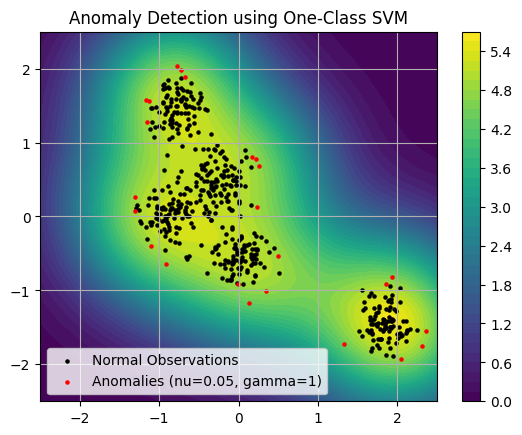

In [4]:
ocsvm = OneClassSVM(nu=0.05, gamma=1).fit(X)
Zp = ocsvm.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = ocsvm.predict(X)
normals = X[y_pred == 1,:]
anomals = X[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=50, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (nu=0.05, gamma=1)')
plt.title('Anomaly Detection using One-Class SVM')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

OC-SVM is known to be sensitive to outliers that already exist in the training data. If these outliers are treated as "normal", or worse, as support vectors, then they will not be flagged as abnormal during testing time. Hence, OC-SVM is only suitable for novelty detection when the training data itself is not contaminated by too many outliers. This method is also efficient when it comes to novelty detection in high-dimensional data.

## Perform Local Outlier Factor

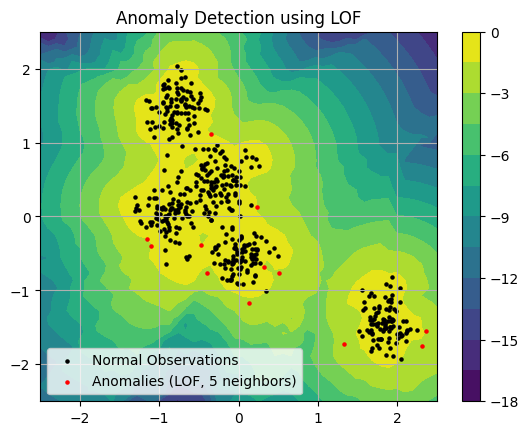

In [5]:
lof = LocalOutlierFactor(n_neighbors=5,novelty=True).fit(X)
Zp = lof.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = lof.predict(X)
normals = X[y_pred == 1,:]
anomals = X[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=10, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (LOF, 5 neighbors)')
plt.title('Anomaly Detection using LOF')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

As seen in the result, the LOF tries to learn the shape of the data set based on the density of points. The less dense the data points, the more likely will they be treated as outliers. However, this also means that if data points are sparsely located **inside** the shape, the LOF will also treat them as outliers.

## Perform Isolation Forest

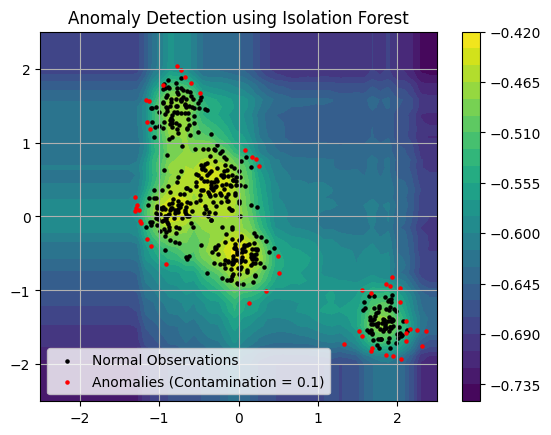

In [6]:
isoforest = IsolationForest(contamination=0.1).fit(X)
Zp = isoforest.score_samples(XY)
Zp = Zp.reshape(Xp.shape)

# Get the anomalous data points
y_pred = isoforest.predict(X)
normals = X[y_pred == 1,:]
anomals = X[y_pred == -1,:]

cntr = plt.contourf(Xp, Yp, Zp, levels=20, cmap='viridis')
plt.scatter(normals[:,0], normals[:,1], s=5, color='k', label='Normal Observations')
plt.scatter(anomals[:,0], anomals[:,1], s=5, color='r', label='Anomalies (Contamination = 0.1)')
plt.title('Anomaly Detection using Isolation Forest')
plt.colorbar(cntr)
plt.legend()
plt.grid()
plt.show()

The Isolation Forest creates grid-like prediction surfaces in the entire space, due to the data splitting nature of the tree ensemble. However, for multi-modal distributed data such as in our example, areas of non-outlier predictions (green) somehow appear at other quadrants where the modes of the data meet, even if no data points are expected to appear there.